In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle


file_path = '/content/IMDb Movies India.csv'
try:

    data = pd.read_csv(file_path, encoding='latin1')
    print("Dataset loaded successfully!")
except UnicodeDecodeError as e:
    print(f"Encoding Error: {e}")
    raise


print("\nDataset Info:")
data.info()
print("\nFirst Few Rows:\n", data.head())

Dataset loaded successfully!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB

First Few Rows:
                                  Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3        

In [3]:

columns_to_drop = ['Title', 'URL']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns], errors='ignore')
print("\nMissing Values:\n", data.isnull().sum())
num_features = data.select_dtypes(include=['int64', 'float64']).columns
cat_features = data.select_dtypes(include=['object']).columns
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

data[num_features] = num_imputer.fit_transform(data[num_features])
data[cat_features] = cat_imputer.fit_transform(data[cat_features])

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Updated parameter
encoded_features = pd.DataFrame(encoder.fit_transform(data[cat_features]),
                                columns=encoder.get_feature_names_out(cat_features),
                                index=data.index)
data = pd.concat([data[num_features], encoded_features], axis=1)


Missing Values:
 Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


In [4]:

def reduce_memory_usage(df):
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

data = reduce_memory_usage(data)


data = data.sample(frac=0.1, random_state=42)

target_column = 'Rating'
X = data.drop(target_column, axis=1)
y = data[target_column]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")



Model Evaluation Metrics:
Mean Squared Error (MSE): 0.9816298246436024
Mean Absolute Error (MAE): 0.6046341094006793
R² Score: -0.0018969091953404682


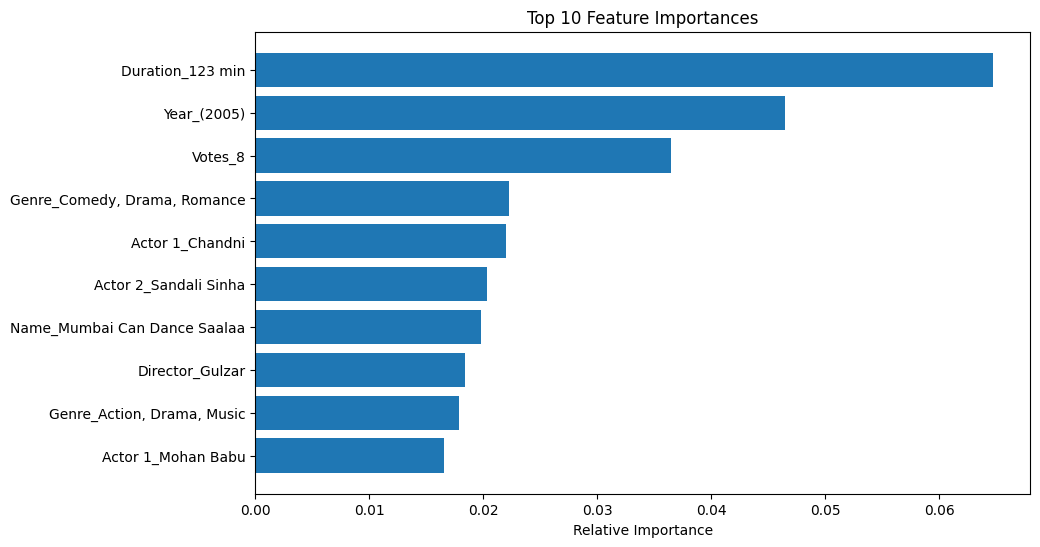


Model saved as 'movie_rating_model.pkl'


In [5]:

importances = model.feature_importances_
indices = np.argsort(importances)[-10:]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


with open('movie_rating_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("\nModel saved as 'movie_rating_model.pkl'")